# Description

From the UCI dataset website: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

**Target variable:**
- default payment (Yes = 1, No = 0)

**Explanatory variables:**
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit
- X2: Gender (1 = Male; 2 = Female)
- X3: Education (1 = Graduate; 2 = University; 3 = High School; 4 = Other)
- X4: Marital status (1 = Married; 2 = Single; 3 = Other)
- X5: Age (year)
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September 2005) as follows: 
    - X6 = repayment status in September
    - ...
    - X11 = repayment status in April 
    - The measurement scale for the repayment status is: 
        - -1 = payments current
        - 1 = delayed payment for 1 month 
        - ...
        - 9 = delayed payment for 9 months and above
- X12-X17: Amount of Billed Statement (NT dollar)
    - X12 = amount of bill statement in September
    - ...
    - X17 = amount of bill statement in April
- X18-X23: Amount of previous payment (NT dollar) 
    - X18 = amount paid in August, 2005
    - X19 = amount paid in August, 2005
    - ...
    - X23 = amount paid in April, 2005


In [1]:
# Importing Packages
import numpy as np 
import pandas as pd
import re
import json
import requests
pd.set_option("display.max_rows", 999)
pd.set_option("display.max_columns", 999)

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_excel("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/default of credit card clients.xls")
new_header = df.iloc[0]
df = df[1:] 
df.columns = new_header
df = df.rename(columns={"default payment next month": "default"}) 
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
1,1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
df.dtypes

0
ID           object
LIMIT_BAL    object
SEX          object
EDUCATION    object
MARRIAGE     object
AGE          object
PAY_0        object
PAY_2        object
PAY_3        object
PAY_4        object
PAY_5        object
PAY_6        object
BILL_AMT1    object
BILL_AMT2    object
BILL_AMT3    object
BILL_AMT4    object
BILL_AMT5    object
BILL_AMT6    object
PAY_AMT1     object
PAY_AMT2     object
PAY_AMT3     object
PAY_AMT4     object
PAY_AMT5     object
PAY_AMT6     object
default      object
dtype: object

# Create train, validation, and holdout sets

In [4]:
X = df.drop(["default"], axis=1)
y = df["default"]
# split the full data 80:20 into training:validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)
# split training data 87.5:12.5 into training:testing sets
X_tr, X_tt, y_tr, y_tt = train_test_split(X_train, y_train, train_size=0.875, random_state=42)
train = pd.concat([X_tr, y_tr], axis=1)
val = pd.concat([X_val, y_val], axis=1)

In [5]:
# X_tt.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/testing.csv")
# y_tt.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/testing_labels.csv")
# train.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/training.csv", index=False)
# val.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/validate.csv", index=False)

# Data Cleaning

In [68]:
tr = pd.read_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/training.csv")
val = pd.read_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/validate.csv")
tr = tr.drop(["ID"], axis=1)
val = val.drop(["ID"], axis=1)
tr.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
default      int64
dtype: object

In [69]:
tr.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,50000,2,2,1,44,0,0,0,0,0,0,45578,41906,35703,22360,23659,27421,3016,5003,3000,3000,5000,924,0
1,160000,2,3,1,46,-1,-1,-1,0,-1,-1,24904,2338,4856,4127,3995,842,2343,4856,1000,3995,842,26313,0
2,100000,2,2,1,47,-1,-1,-1,-1,-1,-2,6666,6666,0,6270,-396,-396,6666,0,6270,0,0,0,1
3,170000,2,2,1,29,0,0,0,0,0,0,79091,62575,63317,63903,43505,43995,2235,2493,2585,1683,1901,2111,0
4,150000,2,1,2,33,-2,-2,-2,-2,-2,-2,24393,26847,32702,33459,27800,2261,27007,32715,33475,27808,2261,169465,0


In [70]:
# Use requests and json modules to webscrape current exchange rate for TWD to USD
url = 'https://openexchangerates.org/api/latest.json?app_id=c51b1508fb4145259b1c2fade72a2c04'
response = requests.get(url)
data = response.json()
rate = data['rates']['TWD']

In [71]:
# change column names for easier reference
data = [tr, val]
for d in data:    
    d.rename(columns={"PAY_0": "stat1", 
                        "PAY_2": "stat2", 
                        "PAY_3": "stat3", 
                        "PAY_4": "stat4",
                        "PAY_5": "stat5", 
                        "PAY_6": "stat6", 
                        "BILL_AMT1": "bill1", 
                        "BILL_AMT2": "bill2", 
                        "BILL_AMT3": "bill3", 
                        "BILL_AMT4": "bill4", 
                        "BILL_AMT5": "bill5", 
                        "BILL_AMT6": "bill6", 
                        "PAY_AMT1": "paid1", 
                        "PAY_AMT2": "paid2", 
                        "PAY_AMT3": "paid3", 
                        "PAY_AMT4": "paid4", 
                        "PAY_AMT5": "paid5", 
                        "PAY_AMT6": "paid6",
                        "SEX": "gender",
                        "EDUCATION": "education",
                        "MARRIAGE": "marriage",
                        "AGE": "age",
                        "LIMIT_BAL": "limit"}, inplace=True)

In [72]:
# Change all TWDs to USDs
for d in data:
    d[['limit']] = d[['limit']]/rate
    d[['bill1', 'bill2', 'bill3', 'bill4', 'bill5', 'bill6']] = d[['bill1', 'bill2', 'bill3', 'bill4', 'bill5', 'bill6']].divide(rate, axis=1)
    d[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']] = d[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']].divide(rate, axis=1)

In [73]:
for d in data:
    d['limit'] = d['limit'].apply(lambda x: round(x, 2))
    d[['bill1', 'bill2', 'bill3', 'bill4', 'bill5', 'bill6']] = d[['bill1', 'bill2', 'bill3', 'bill4', 'bill5', 'bill6']].apply(lambda x: round(x, 2))
    d[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']] = d[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']].apply(lambda x: round(x, 2))

In [74]:
tr.describe()

,limit,gender,education,marriage,age,stat1,stat2,stat3,stat4,stat5,stat6,bill1,bill2,bill3,bill4,bill5,bill6,paid1,paid2,paid3,paid4,paid5,paid6,default
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,5968.019112,1.605190,1.854333,1.549476,35.538286,-0.015524,-0.130952,-0.165667,-0.216952,-0.261238,-0.284810,1824.361783,1754.724652,1676.311073,1540.945459,1441.064545,1391.08761,204.582616,214.361145,188.426632,175.860581,172.110534,184.047153,0.221714
std,4624.128573,0.488821,0.794086,0.523126,9.257936,1.127750,1.200066,1.194393,1.170611,1.136246,1.156573,2622.195093,2540.316216,2484.295549,2294.373102,2177.287656,2129.89528,624.977750,895.340071,665.539059,599.729322,557.489339,630.255739,0.415410
min,356.910000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-5909.670000,-2490.390000,-5612.860000,-6067.420000,-2902.870000,-7461.18000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1784.540000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,127.292500,108.270000,97.925000,83.900000,63.600000,46.46000,35.690000,29.840000,13.920000,10.390000,8.670000,4.170000,0.000000
50%,4996.700000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,801.630000,764.390000,716.420000,679.495000,646.000000,611.33000,74.950000,71.630000,64.240000,53.540000,53.540000,53.540000,0.000000
75%,8565.770000,2.000000,2.000000,2.000000,42.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2382.705000,2258.912500,2130.530000,1939.627500,1794.860000,1763.58500,178.700000,178.450000,160.610000,142.800000,143.975000,142.760000,0.000000
max,35690.700000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,34424.080000,35117.190000,59392.510000,31821.330000,33091.390000,34322.47000,31177.690000,60112.390000,31980.300000,22163.930000,14918.360000,18814.100000,1.000000


In [75]:
# put all zero values into category of 3 for marriage
# lump all the other and unknown education categories together:  0, 5, 6 values to category 4
for d in data:  
    d.replace({'marriage': {0:3}}, inplace=True)
    d.replace({'education': {5:4, 0:4, 6:4}}, inplace=True)

In [76]:
# -2 is the same as -1. but turn them all into 0's, since it makes more sense within context or meaning, i.e. client is zero months behind payment
datasets = ['stat1', 'stat2', 'stat3', 'stat4', 'stat5', 'stat6']
for data in datasets:
    tr.replace({data: {-2: 0, -1: 0}}, inplace=True)
    val.replace({data: {-2: 0, -1: 0}}, inplace=True)

In [16]:
tr.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/train_cleaned.csv", index=False)
val.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/validate_cleaned.csv", index=False)

# Exploratory Data Analysis

<AxesSubplot:>

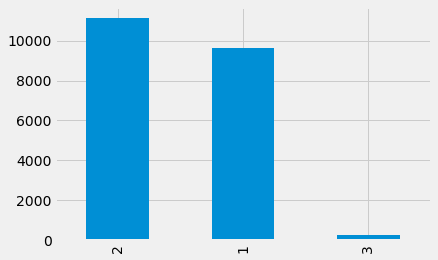

In [17]:
tr.marriage.value_counts().plot(kind = 'bar')

<AxesSubplot:>

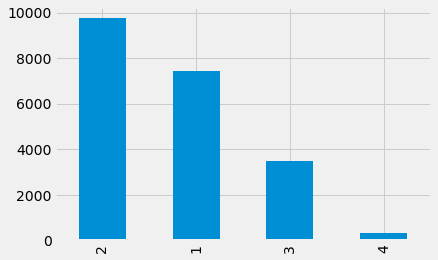

In [18]:
tr.education.value_counts().plot(kind="bar")

In [32]:
billed = tr[['bill1', 'bill2', 'bill3', 'bill4', 'bill5', 'bill6']]
status = tr[['stat1', 'stat2', 'stat3', 'stat4', 'stat5', 'stat6']]
paid = tr[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']]
bill_col = billed.columns
stat_col = status.columns
paid_col = paid.columns

In [26]:
con_1 = pd.melt(tr, value_vars = billed_con)
g = sns.FacetGrid(con_1, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
g = g.map(sns.distplot, 'value', color='r')
g.set_xticklabels(rotation=45)
plt.savefig("images/df_distplot.png")

# Create scatterplots with regression line with regplot() of continuous variables

# con_2 = pd.melt(df, id_vars='price', value_vars=col_con)
# g = sns.FacetGrid(con_2, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
# g = g.map(sns.regplot, 'value', 'price', color='darkorange')
# g.set_xticklabels(rotation=45)
# plt.savefig('images/df_scatter.png')

# Use bar graphs of the distribution of data for categorical variables

# cat_1 = pd.melt(df, value_vars=col_cat)
# g = sns.FacetGrid(cat_1, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
# g = g.map(sns.countplot, 'value', color='g')
# g.set_xticklabels(rotation=90)
# plt.savefig("images/df_countplot.png")

# Create scatterplots for categorical variables to observe any relationships

# cat_2 = pd.melt(df,id_vars='price', value_vars=col_cat)
# g = sns.FacetGrid(cat_2, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
# g = g.map(sns.regplot, 'value', 'price', color='dodgerblue')
# g.set_xticklabels(rotation=90)
# plt.savefig("images/df_regplot.png")

# Display boxplots of categorical variables to observe any trends in the mean values of each category

# cat_3 = pd.melt(df, id_vars='price', value_vars=col_cat)
# g = sns.FacetGrid(cat_3, col='variable', col_wrap=3, sharex=False, sharey=False, height=4)
# g = g.map(sns.boxplot, 'value', 'price', color='mediumslateblue')
# g.set_xticklabels(rotation=90)
# plt.savefig("images/df_boxplot.png")

In [19]:
def histogram(df, features, rows, cols, bins):
    fig = plt.figure(figsize=(16, 16))
    for i, feature in enumerate(features):
        ax = fig.add_subplot(rows, cols, i+1)
        df[feature].hist(bins=bins, ax=ax)
        ax.set_title(feature)
    fig.tight_layout()
    plt.show()

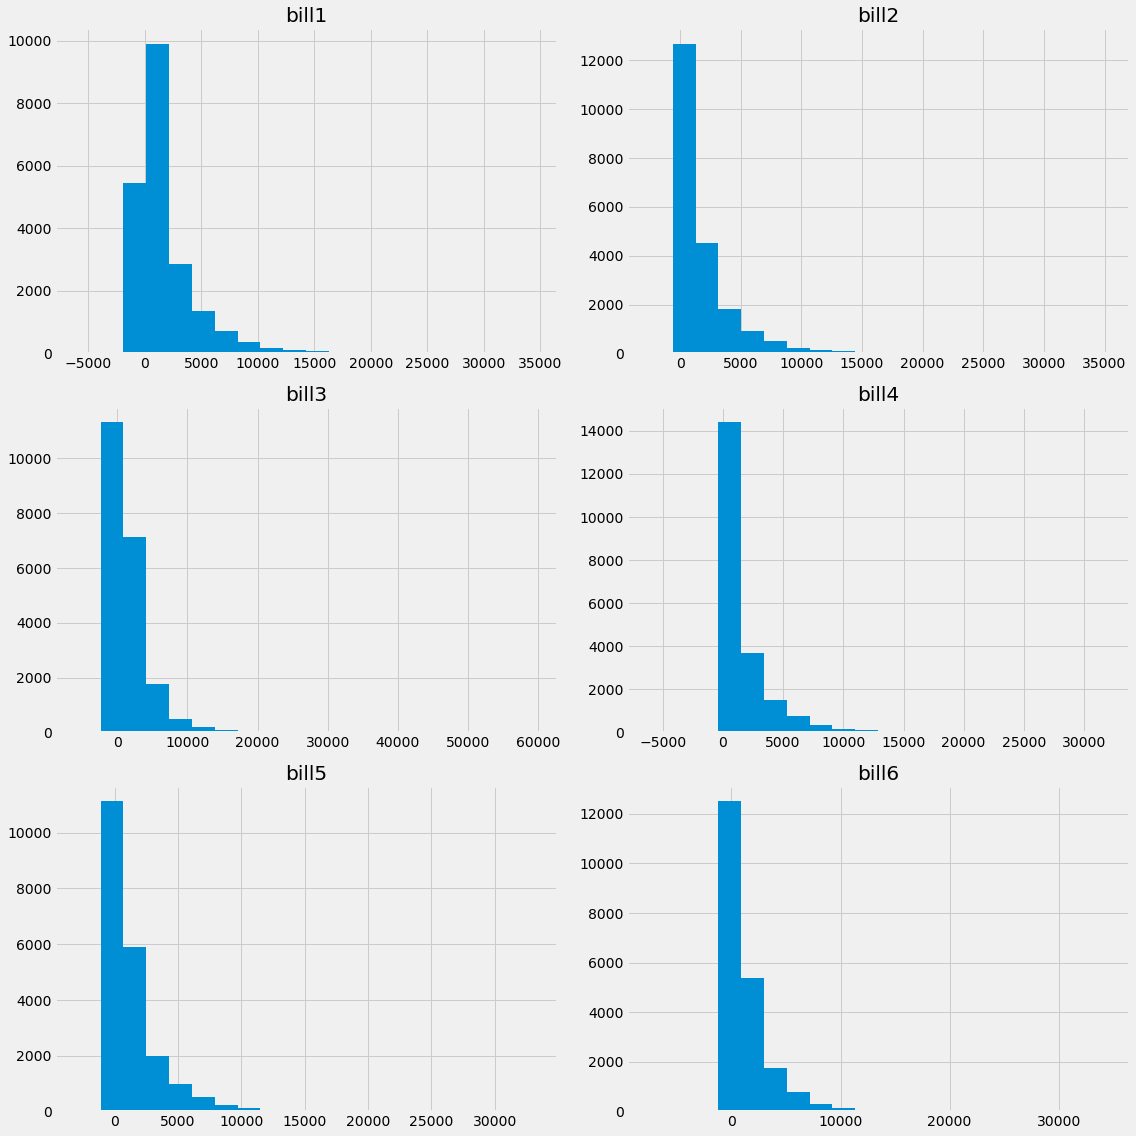

In [20]:
billed = tr[['bill1', 'bill2', 'bill3', 'bill4', 'bill5', 'bill6']]
histogram(billed, billed.columns, 3, 2, 20)

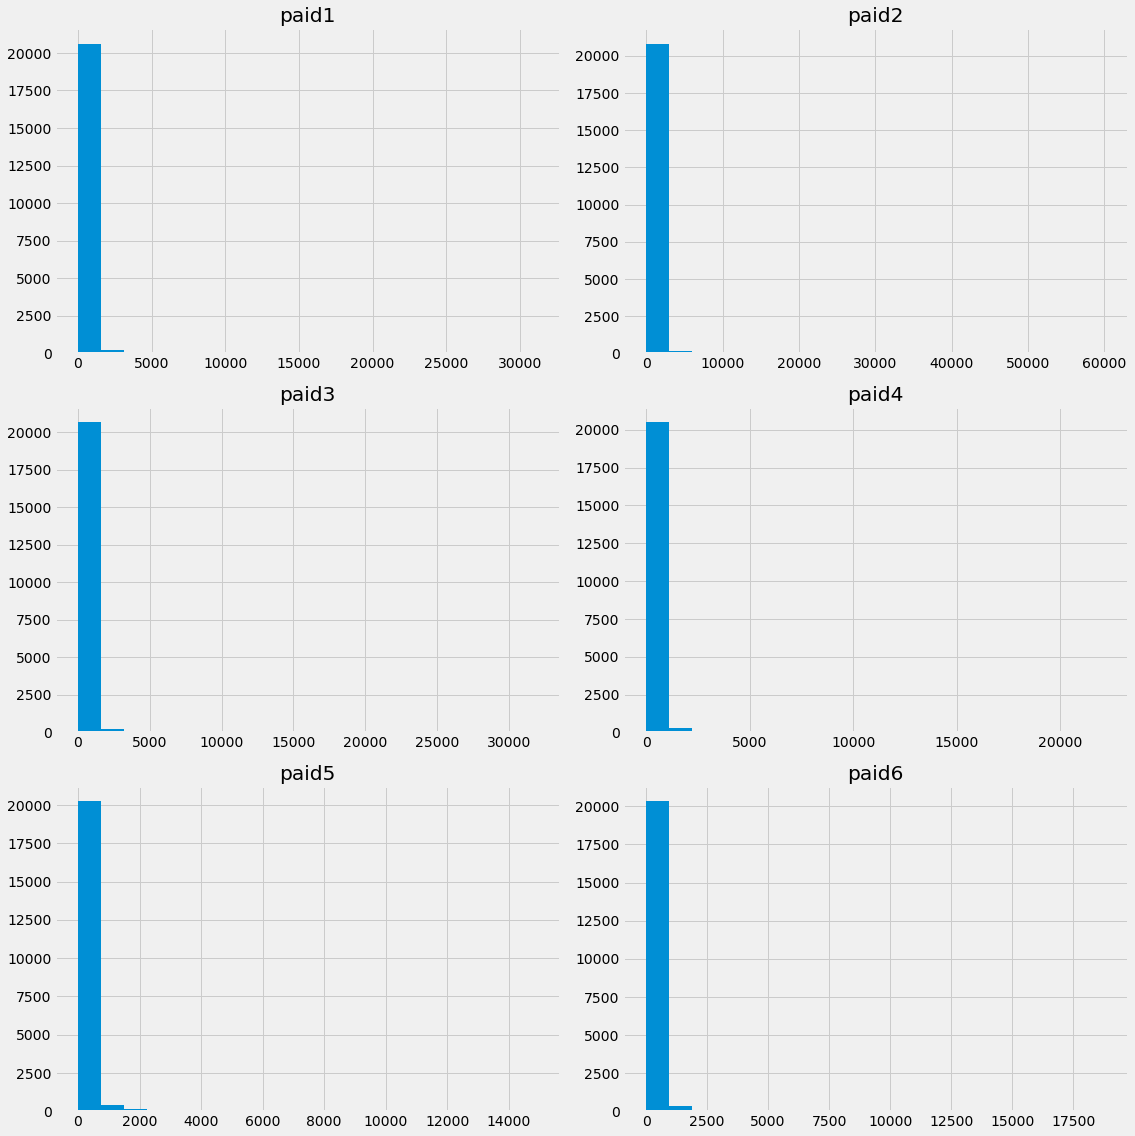

In [21]:
paid = tr[['paid1', 'paid2', 'paid3', 'paid4', 'paid5', 'paid6']]
histogram(paid, paid.columns, 3, 2, 20)

<AxesSubplot:>

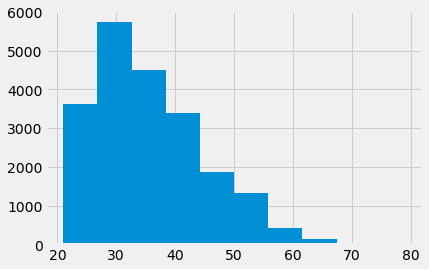

In [22]:
tr.age.hist()

<AxesSubplot:>

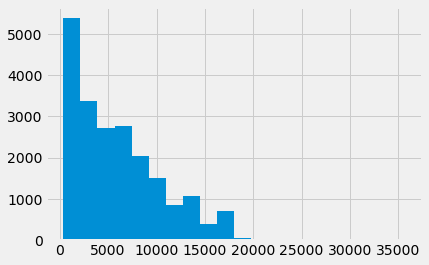

In [23]:
tr.limit.hist(bins=20)

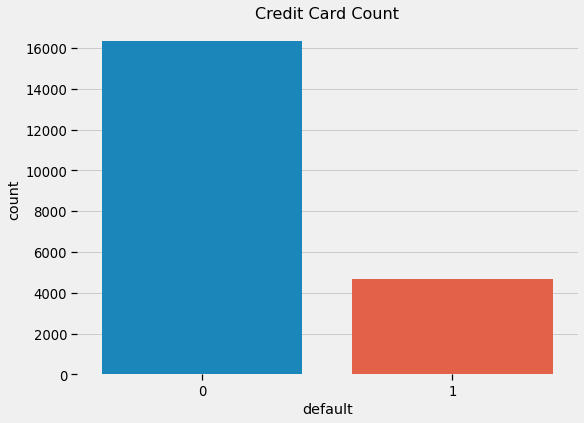

In [24]:
yes = tr.default.sum()
no = len(tr)-yes
perc_y = round(yes/len(tr)*100, 1)
perc_n = round(no/len(tr)*100, 1)

plt.figure(figsize=(8,6))
sns.set_context('notebook', font_scale=1.2)
sns.countplot('default', data=tr)
plt.title('Credit Card Count', size=16)
plt.box(False);

In [25]:
print(yes)
print(no)
print(perc_y)
print(perc_n)

4656
16344
22.2
77.8


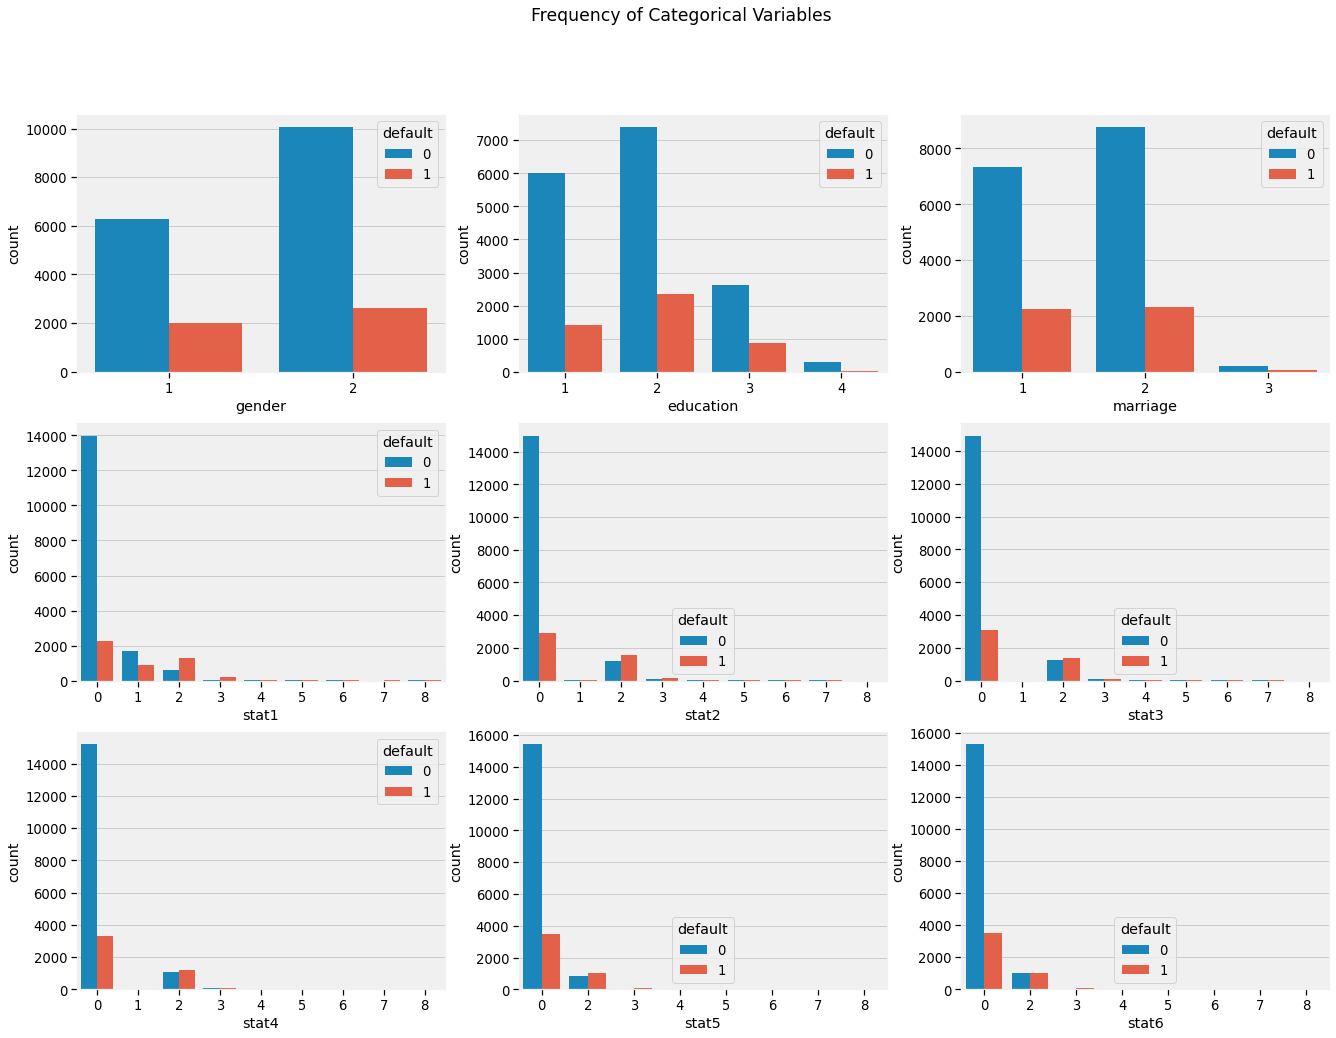

In [27]:
subset = tr[['gender', 'education', 'marriage', 'stat1', 'stat2', 'stat3', 'stat4', 'stat5', 'stat6', 'default']]
f, axes = plt.subplots(3, 3, figsize=(20, 15), facecolor='white')
f.suptitle('Frequency of Categorical Variables')
ax1 = sns.countplot(x="gender", hue="default", data=subset, ax=axes[0,0])
ax2 = sns.countplot(x="education", hue="default", data=subset, ax=axes[0,1])
ax3 = sns.countplot(x="marriage", hue="default", data=subset, ax=axes[0,2])
ax4 = sns.countplot(x="stat1", hue="default", data=subset, ax=axes[1,0])
ax5 = sns.countplot(x="stat2", hue="default", data=subset, ax=axes[1,1])
ax6 = sns.countplot(x="stat3", hue="default", data=subset, ax=axes[1,2])
ax7 = sns.countplot(x="stat4", hue="default", data=subset, ax=axes[2,0])
ax8 = sns.countplot(x="stat5", hue="default", data=subset, ax=axes[2,1])
ax9 = sns.countplot(x="stat6", hue="default", data=subset, ax=axes[2,2]);

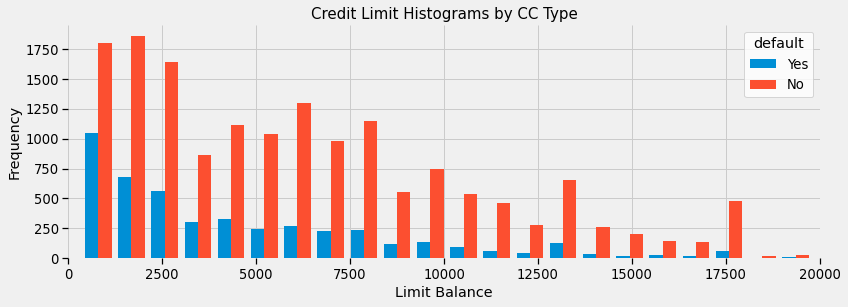

In [28]:
x1 = list(tr[tr['default'] == 1]['limit'])
x2 = list(tr[tr['default'] == 0]['limit'])

plt.figure(figsize=(12,4))
sns.set_context('notebook', font_scale=1.2)
#sns.set_color_codes("pastel")
plt.hist([x1, x2], bins = 40)
plt.xlim([0, 20000])
plt.legend(['Yes', 'No'], title = 'default', loc='upper right', facecolor='white')
plt.xlabel('Limit Balance')
plt.ylabel('Frequency')
plt.title('Credit Limit Histograms by CC Type', SIZE=15)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

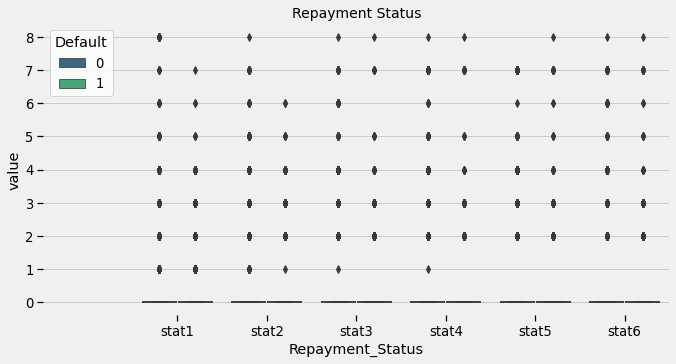

In [29]:
status = tr[['stat1', 'stat2', 'stat3', 'stat4', 'stat5', 'stat6']]
status = pd.concat([y, status],axis=1)
status = pd.melt(status,id_vars="default",
                    var_name="Repayment_Status",
                    value_name='value')

plt.figure(figsize=(10,5))
sns.set_context('notebook', font_scale=1.2)
sns.boxplot(y="value", x="Repayment_Status", hue="default", data=status, palette='viridis')
plt.legend(loc='best', title= 'Default', facecolor='white')
plt.xlim([-1.5,5.5])
plt.title('Repayment Status', size=14)
plt.box(False)

In [59]:
tr.head()

,limit,gender,education,marriage,age,stat1,stat2,stat3,stat4,stat5,stat6,bill1,bill2,bill3,bill4,bill5,bill6,paid1,paid2,paid3,paid4,paid5,paid6,default
0,1784.98,2,2,1,44,0,0,0,0,0,0,1627.12,1496.03,1274.58,798.24,844.62,978.92,107.67,178.61,107.10,107.10,178.50,32.99,0
1,5711.94,2,3,1,46,0,0,0,0,0,0,889.06,83.47,173.36,147.33,142.62,30.06,83.64,173.36,35.70,142.62,30.06,939.36,0
2,3569.96,2,2,1,47,0,0,0,0,0,0,237.97,237.97,0.00,223.84,-14.14,-14.14,237.97,0.00,223.84,0.00,0.00,0.00,1
3,6068.94,2,2,1,29,0,0,0,0,0,0,2823.52,2233.90,2260.39,2281.31,1553.11,1570.60,79.79,89.00,92.28,60.08,67.86,75.36,0
4,5354.94,2,1,2,33,0,0,0,0,0,0,870.82,958.43,1167.45,1194.47,992.45,80.72,964.14,1167.91,1195.04,992.74,80.72,6049.84,0


In [34]:
tr[['limit', 'paid6', 'bill6', 'paid5', 'stat6', 'bill5', 'paid4', 'stat5', 'bill4', 'paid3', 'stat4', 'bill3', 'paid2', 'stat3', 'bill2', 'paid1', 'stat2', 'bill1', 'stat1']]

,limit,paid6,bill6,paid5,stat6,bill5,paid4,stat5,bill4,paid3,stat4,bill3,paid2,stat3,bill2,paid1,stat2,bill1,stat1
0,1784.98,32.99,978.92,178.50,0,844.62,107.10,0,798.24,107.10,0,1274.58,178.61,0,1496.03,107.67,0,1627.12,0
1,5711.94,939.36,30.06,30.06,0,142.62,142.62,0,147.33,35.70,0,173.36,173.36,0,83.47,83.64,0,889.06,0
2,3569.96,0.00,-14.14,0.00,0,-14.14,0.00,0,223.84,223.84,0,0.00,0.00,0,237.97,237.97,0,237.97,0
3,6068.94,75.36,1570.60,67.86,0,1553.11,60.08,0,2281.31,92.28,0,2260.39,89.00,0,2233.90,79.79,0,2823.52,0
4,5354.94,6049.84,80.72,80.72,0,992.45,992.74,0,1194.47,1195.04,0,1167.45,1167.91,0,958.43,964.14,0,870.82,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,7853.92,14.14,19.49,19.49,0,14.14,14.14,0,14.14,14.14,0,14.14,14.14,0,14.14,0.00,2,28.27,0
20996,4997.95,80.86,62.26,62.44,0,17.67,17.71,0,91.86,92.11,0,54.05,54.33,0,183.85,72.26,0,104.85,0
20997,713.99,0.00,732.81,41.09,0,701.35,23.49,0,682.01,0.00,2,707.57,101.10,2,616.60,35.70,2,601.72,2
20998,1070.99,0.00,772.22,71.40,2,717.53,71.40,0,657.44,47.02,0,631.78,0.00,2,652.37,113.35,2,548.38,2


In [35]:
tr[tr.default == 1][['limit', 'paid6', 'bill6', 'paid5', 'stat6', 'bill5', 'paid4', 'stat5', 'bill4', 'paid3', 'stat4', 'bill3', 'paid2', 'stat3', 'bill2', 'paid1', 'stat2', 'bill1', 'stat1']]

,limit,paid6,bill6,paid5,stat6,bill5,paid4,stat5,bill4,paid3,stat4,bill3,paid2,stat3,bill2,paid1,stat2,bill1,stat1
2,3569.96,0.00,-14.14,0.00,0,-14.14,0.00,0,223.84,223.84,0,0.00,0.00,0,237.97,237.97,0,237.97,0
6,713.99,39.27,704.46,35.70,0,717.13,731.84,0,29.67,29.67,0,196.03,35.70,0,713.06,53.55,0,702.10,0
7,1070.99,49.98,1012.23,0.00,2,1033.61,83.25,0,977.42,62.76,0,941.15,0.00,2,966.67,0.00,3,992.70,1
11,3569.96,160.65,3775.27,128.52,2,3769.81,142.80,2,3836.17,132.09,2,3868.05,192.78,2,3819.90,203.49,2,3761.78,2
24,1784.98,0.00,641.95,71.40,2,580.23,0.00,2,594.83,35.70,2,579.30,71.40,2,516.75,0.00,2,535.71,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20983,5354.94,131.52,3123.72,2855.97,0,291.77,29.38,0,266.82,4283.95,0,5264.77,107.10,0,5415.13,4820.09,0,629.56,2
20984,1784.98,21.42,723.38,249.90,0,717.03,107.10,0,844.83,212.27,0,1523.37,89.25,0,1696.34,78.54,0,1691.23,0
20987,6068.94,26.42,26.42,26.42,0,26.42,26.42,0,26.42,26.42,0,26.42,26.42,0,26.42,26.42,0,26.42,0
20997,713.99,0.00,732.81,41.09,0,701.35,23.49,0,682.01,0.00,2,707.57,101.10,2,616.60,35.70,2,601.72,2


In [36]:
tr[tr.default == 1][['limit', 'bill6', 'paid6', 'stat6', 'bill5', 'paid5', 'stat5', 'bill4', 'paid4', 'stat4', 'bill3', 'paid3', 'stat3', 'bill2', 'paid2', 'stat2', 'bill1', 'paid1', 'stat1']]

,limit,bill6,paid6,stat6,bill5,paid5,stat5,bill4,paid4,stat4,bill3,paid3,stat3,bill2,paid2,stat2,bill1,paid1,stat1
2,3569.96,-14.14,0.00,0,-14.14,0.00,0,223.84,0.00,0,0.00,223.84,0,237.97,0.00,0,237.97,237.97,0
6,713.99,704.46,39.27,0,717.13,35.70,0,29.67,731.84,0,196.03,29.67,0,713.06,35.70,0,702.10,53.55,0
7,1070.99,1012.23,49.98,2,1033.61,0.00,0,977.42,83.25,0,941.15,62.76,2,966.67,0.00,3,992.70,0.00,1
11,3569.96,3775.27,160.65,2,3769.81,128.52,2,3836.17,142.80,2,3868.05,132.09,2,3819.90,192.78,2,3761.78,203.49,2
24,1784.98,641.95,0.00,2,580.23,71.40,2,594.83,0.00,2,579.30,35.70,2,516.75,71.40,2,535.71,0.00,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20983,5354.94,3123.72,131.52,0,291.77,2855.97,0,266.82,29.38,0,5264.77,4283.95,0,5415.13,107.10,0,629.56,4820.09,2
20984,1784.98,723.38,21.42,0,717.03,249.90,0,844.83,107.10,0,1523.37,212.27,0,1696.34,89.25,0,1691.23,78.54,0
20987,6068.94,26.42,26.42,0,26.42,26.42,0,26.42,26.42,0,26.42,26.42,0,26.42,26.42,0,26.42,26.42,0
20997,713.99,732.81,0.00,0,701.35,41.09,0,682.01,23.49,2,707.57,0.00,2,616.60,101.10,2,601.72,35.70,2


In [37]:
sex = tr.groupby(['gender', 'default']).size().unstack(1)
sex

default,0,1
gender,,
1,6272,2019
2,10072,2637


<AxesSubplot:xlabel='gender'>

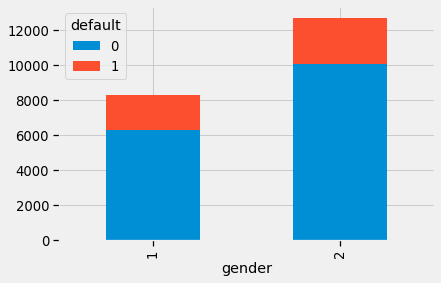

In [38]:
sex.plot(kind="bar", stacked=True)

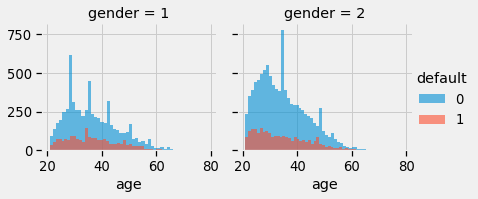

In [85]:
g = sns.FacetGrid(tr, col='gender', hue='default')
g.map(plt.hist, 'age', alpha=0.6, bins=50)
g.add_legend()

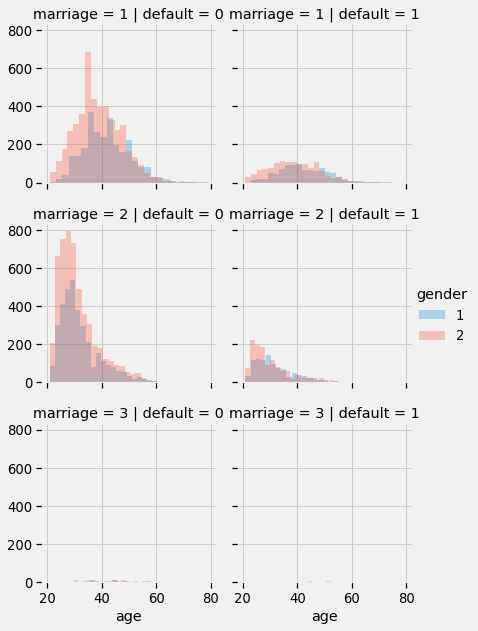

In [40]:
g = sns.FacetGrid(tr, col='default', row="marriage", hue='gender')
g.map(plt.hist, 'age', alpha=0.3, bins=50) 
g.add_legend()

In [41]:
def group_perc(col1, col2):
    res = tr.groupby([col1, col2]).size().unstack()
    res['perc'] = (res[res.columns[1]]/(res[res.columns[0]] + res[res.columns[1]]))
    return res

# Feature Engineering

In [77]:
data = [tr, val]
for d in data:
    d['age_bin'] = 0
    d.loc[((d['age'] > 20) & (d['age'] < 30)) , 'age_bin'] = 1
    d.loc[((d['age'] >= 30) & (d['age'] < 40)) , 'age_bin'] = 2
    d.loc[((d['age'] >= 40) & (d['age'] < 50)) , 'age_bin'] = 3
    d.loc[((d['age'] >= 50) & (d['age'] < 60)) , 'age_bin'] = 4 
    d.loc[((d['age'] >= 60) & (d['age'] < 70)) , 'age_bin'] = 5
    d.loc[((d['age'] >= 70) & (d['age'] < 81)) , 'age_bin'] = 6


In [78]:
tr.age_bin.value_counts()

2    7824
1    6693
3    4583
4    1652
5     228
6      20
Name: age_bin, dtype: int64

In [79]:
# fraction of estimated available balance based on what is billed per month and credit limit
for d in data:
    d['avail6'] = (d.limit - d.bill6) / d.limit
    d['avail5'] = (d.limit - d.bill5) / d.limit
    d['avail4'] = (d.limit - d.bill4) / d.limit
    d['avail3'] = (d.limit - d.bill3) / d.limit
    d['avail2'] = (d.limit - d.bill2) / d.limit
    d['avail1'] = (d.limit - d.bill1) / d.limit

In [80]:
tr.head()

,limit,gender,education,marriage,age,stat1,stat2,stat3,stat4,stat5,stat6,bill1,bill2,bill3,bill4,bill5,bill6,paid1,paid2,paid3,paid4,paid5,paid6,default,age_bin,avail6,avail5,avail4,avail3,avail2,avail1
0,1784.54,2,2,1,44,0,0,0,0,0,0,1626.71,1495.65,1274.27,798.04,844.41,978.67,107.64,178.56,107.07,107.07,178.45,32.98,0,3,0.451584,0.526819,0.552804,0.285939,0.161885,0.088443
1,5710.51,2,3,1,46,0,0,0,0,0,0,888.84,83.44,173.31,147.30,142.58,30.05,83.62,173.31,35.69,142.58,30.05,939.13,0,3,0.994738,0.975032,0.974205,0.969651,0.985388,0.844350
2,3569.07,2,2,1,47,0,0,0,0,0,0,237.91,237.91,0.00,223.78,-14.13,-14.13,237.91,0.00,223.78,0.00,0.00,0.00,1,3,1.003959,1.003959,0.937300,1.000000,0.933341,0.933341
3,6067.42,2,2,1,29,0,0,0,0,0,0,2822.81,2233.35,2259.83,2280.74,1552.72,1570.21,79.77,88.98,92.26,60.07,67.85,75.34,0,1,0.741206,0.744089,0.624101,0.627547,0.631911,0.534759
4,5353.61,2,1,2,33,0,0,0,0,0,0,870.60,958.19,1167.16,1194.18,992.20,80.70,963.90,1167.62,1194.75,992.49,80.70,6048.33,0,2,0.984926,0.814667,0.776939,0.781986,0.821020,0.837381


In [81]:
for d in data:
    d['avg_av'] = (d.avail1 + d.avail2 + d.avail3 + d.avail4 + d.avail5 + d.avail6) / 6

In [86]:
# the ratio of amount paid and amount billed
for d in data:
    d['pperb1'] = d.paid1 / d.bill2
    d['pperb2'] = d.paid2 / d.bill3
    d['pperb3'] = d.paid3 / d.bill4
    d['pperb4'] = d.paid4 / d.bill5
    d['pperb5'] = d.paid5 / d.bill6

In [87]:
tr.head(30)

,limit,gender,education,marriage,age,stat1,stat2,stat3,stat4,stat5,stat6,bill1,bill2,bill3,bill4,bill5,bill6,paid1,paid2,paid3,paid4,paid5,paid6,default,age_bin,avail6,avail5,avail4,avail3,avail2,avail1,avg_av,pperb1,pperb2,pperb3,pperb4,pperb5
0,1784.54,2,2,1,44,0,0,0,0,0,0,1626.71,1495.65,1274.27,798.04,844.41,978.67,107.64,178.56,107.07,107.07,178.45,32.98,0,3,0.451584,0.526819,0.552804,0.285939,0.161885,0.088443,0.344579,0.071969,0.140127,0.134166,0.126799,0.182339
1,5710.51,2,3,1,46,0,0,0,0,0,0,888.84,83.44,173.31,147.30,142.58,30.05,83.62,173.31,35.69,142.58,30.05,939.13,0,3,0.994738,0.975032,0.974205,0.969651,0.985388,0.844350,0.957227,1.002157,1.000000,0.242295,1.000000,1.000000
2,3569.07,2,2,1,47,0,0,0,0,0,0,237.91,237.91,0.00,223.78,-14.13,-14.13,237.91,0.00,223.78,0.00,0.00,0.00,1,3,1.003959,1.003959,0.937300,1.000000,0.933341,0.933341,0.968650,1.000000,NaN,1.000000,-0.000000,-0.000000
3,6067.42,2,2,1,29,0,0,0,0,0,0,2822.81,2233.35,2259.83,2280.74,1552.72,1570.21,79.77,88.98,92.26,60.07,67.85,75.34,0,1,0.741206,0.744089,0.624101,0.627547,0.631911,0.534759,0.650602,0.035718,0.039375,0.040452,0.038687,0.043211
4,5353.61,2,1,2,33,0,0,0,0,0,0,870.60,958.19,1167.16,1194.18,992.20,80.70,963.90,1167.62,1194.75,992.49,80.70,6048.33,0,2,0.984926,0.814667,0.776939,0.781986,0.821020,0.837381,0.836153,1.005959,1.000394,1.000477,1.000292,1.000000
5,1784.54,1,3,2,37,0,0,0,0,0,0,722.67,1812.98,1903.74,1629.67,720.24,755.04,1625.18,124.92,50.82,71.38,46.40,26.91,0,2,0.576899,0.596400,0.086784,-0.066796,-0.015937,0.595038,0.295398,0.896414,0.065618,0.031184,0.099106,0.061454
6,713.81,2,2,1,22,0,0,0,0,0,0,701.93,712.89,195.98,29.66,716.95,704.28,53.54,35.69,29.66,731.66,35.69,39.26,1,1,0.013351,-0.004399,0.958448,0.725445,0.001289,0.016643,0.285130,0.075103,0.182110,1.000000,1.020517,0.050676
7,1070.72,2,2,1,32,1,3,2,0,0,2,992.45,966.43,940.91,977.18,1033.35,1011.97,0.00,0.00,62.74,83.23,0.00,49.97,1,2,0.054870,0.034902,0.087362,0.121236,0.097402,0.073100,0.078145,0.000000,0.000000,0.064205,0.080544,0.000000
8,5710.51,2,1,2,27,0,0,0,0,0,0,10.28,16.10,59.43,11.78,5.89,28.34,16.10,59.96,11.78,0.00,28.34,83.84,0,1,0.995037,0.998969,0.997937,0.989593,0.997181,0.998200,0.996153,1.000000,1.008918,1.000000,0.000000,1.000000
9,7495.05,1,1,1,30,0,0,0,0,0,2,2341.31,2262.65,2289.56,2360.40,2502.56,2400.34,82.09,107.07,107.07,178.45,0.00,107.07,0,2,0.679743,0.666105,0.685072,0.694524,0.698114,0.687619,0.685196,0.036280,0.046764,0.045361,0.071307,0.000000


In [88]:
tr.pperb1.value_counts()

 1.000000    2854
 0.000000    1945
 inf           29
-1.000000      22
 2.000000      10
             ... 
 0.045363       1
 0.047628       1
 0.240636       1
 0.051340       1
 0.035237       1
Name: pperb1, Length: 14357, dtype: int64

In [91]:
datasets = ['pperb1', 'pperb2', 'pperb3', 'pperb4', 'pperb5']
for data in datasets:
    tr.replace({data: {np.inf: 0, np.nan: 0}}, inplace=True)
    val.replace({data: {np.inf: 0, np.nan: 0}}, inplace=True)

In [92]:
tr.head()

,limit,gender,education,marriage,age,stat1,stat2,stat3,stat4,stat5,stat6,bill1,bill2,bill3,bill4,bill5,bill6,paid1,paid2,paid3,paid4,paid5,paid6,default,age_bin,avail6,avail5,avail4,avail3,avail2,avail1,avg_av,pperb1,pperb2,pperb3,pperb4,pperb5
0,1784.54,2,2,1,44,0,0,0,0,0,0,1626.71,1495.65,1274.27,798.04,844.41,978.67,107.64,178.56,107.07,107.07,178.45,32.98,0,3,0.451584,0.526819,0.552804,0.285939,0.161885,0.088443,0.344579,0.071969,0.140127,0.134166,0.126799,0.182339
1,5710.51,2,3,1,46,0,0,0,0,0,0,888.84,83.44,173.31,147.30,142.58,30.05,83.62,173.31,35.69,142.58,30.05,939.13,0,3,0.994738,0.975032,0.974205,0.969651,0.985388,0.844350,0.957227,1.002157,1.000000,0.242295,1.000000,1.000000
2,3569.07,2,2,1,47,0,0,0,0,0,0,237.91,237.91,0.00,223.78,-14.13,-14.13,237.91,0.00,223.78,0.00,0.00,0.00,1,3,1.003959,1.003959,0.937300,1.000000,0.933341,0.933341,0.968650,1.000000,0.000000,1.000000,-0.000000,-0.000000
3,6067.42,2,2,1,29,0,0,0,0,0,0,2822.81,2233.35,2259.83,2280.74,1552.72,1570.21,79.77,88.98,92.26,60.07,67.85,75.34,0,1,0.741206,0.744089,0.624101,0.627547,0.631911,0.534759,0.650602,0.035718,0.039375,0.040452,0.038687,0.043211
4,5353.61,2,1,2,33,0,0,0,0,0,0,870.60,958.19,1167.16,1194.18,992.20,80.70,963.90,1167.62,1194.75,992.49,80.70,6048.33,0,2,0.984926,0.814667,0.776939,0.781986,0.821020,0.837381,0.836153,1.005959,1.000394,1.000477,1.000292,1.000000


In [94]:
tr.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/train_feature.csv", index=False)
val.to_csv("/Volumes/My Passport for Mac/Dropbox/Data Science/Flatiron/iPython Notebooks/course-materials/DS-Projects/Taiwan-CC-Default-Prediction/data/validate_feature.csv", index=False)